<a href="https://colab.research.google.com/github/flrain2/Study/blob/main/multimodal_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install --upgrade pip -U langchain openai chromadb langchain-experimental

In [ ]:
# ! pip install --upgrade onnx==1.16.2

In [ ]:
#! pip install "unstructured[all-docs]" pillow pydantic lxml pillow matplotlib chromadb tiktoken

In [ ]:
! pip install "unstructured[all-docs]" tiktoken

In [ ]:
! pip install "unstructured[all-docs]" chromadb

In [ ]:
! pip install "unstructured[all-docs]" matplotlib

In [ ]:
! pip install "unstructured[all-docs]" pillow

In [ ]:
! pip install "unstructured[all-docs]" pydantic

In [ ]:
! pip install "unstructured[all-docs]" lxml

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# 데이터 로딩
## PDF 텍스트와 이미지 분할
Unstructured에서 제공하는 partition_pdf를 사용하여 텍스트와 이미지를 추출할 수 있습니다.

이미지를 추출하기 위해 다음을 사용합니다

extract_images_in_pdf=True

텍스트만 처리하려는 경우.

extract_images_in_pdf=False

In [ ]:
pwd

'/content'

In [ ]:
# 파일 경로
fpath = "gdrive/MyDrive/Colab Notebooks/multi-modal"
fname = "kb_heal.pdf"

In [ ]:

import pdfplumber
import os
from PIL import Image
from langchain_text_splitters import CharacterTextSplitter

def extract_pdf_elements(path, fname):
    """
    Extracts images, tables, and text from a PDF file.

    path: Directory path where images (.jpg) will be saved.
    fname: File name of the PDF.
    """
    elements = []
    pdf_path = os.path.join(path, fname)

    # Open the PDF
    with pdfplumber.open(pdf_path) as pdf:
        for i, page in enumerate(pdf.pages):
            # Extract text
            text = page.extract_text()
            if text:
                elements.append({"type": "text", "content": text})

            # Extract table
            table = page.extract_table()
            if table:
                elements.append({"type": "table", "content": table})

            # Extract images
            for idx, img in enumerate(page.images):
                # Set image coordinates, clamping them within the page bounds
                x0 = max(img["x0"], 0)
                top = max(img["top"], 0)
                x1 = min(img["x1"], page.width)
                bottom = min(img["bottom"], page.height)

                # Check if the adjusted bounding box is valid
                if x0 < x1 and top < bottom:
                    # Crop the image from the page
                    cropped_image = page.within_bbox((x0, top, x1, bottom)).to_image()

                    # Convert to PIL Image and RGB mode if necessary
                    pil_image = cropped_image.original
                    if pil_image.mode != "RGB":
                        pil_image = pil_image.convert("RGB")

                    # Set image path (include page and coordinates for clarity)
                    img_path = os.path.join(path, f"page_{i+1}_image_{idx}_({x0}_{top}).jpg")
                    pil_image.save(img_path, format="JPEG")

                    elements.append({"type": "image", "content": img_path})

    return elements

def categorize_elements(raw_pdf_elements):
    """
    PDF에서 추출된 요소를 테이블과 텍스트로 분류합니다.

    raw_pdf_elements: 요소들이 담긴 리스트 (각 요소는 딕셔너리로 구성)
    """
    tables = []  # 테이블 저장 리스트
    texts = []   # 텍스트 저장 리스트
    for element in raw_pdf_elements:
        # 요소가 dict 형태인지 확인
        if isinstance(element, dict) and 'type' in element:
            # 'type' 필드에 따라 분류
            if element['type'] == 'table':
                print(f"Table element: {element}")
                tables.append(element['content'])  # 테이블 요소 추가
            elif element['type'] == 'text':
                #print(f"Text element: {element}")
                texts.append(element['content'])  # 텍스트 요소 추가
    return texts, tables

# 요소 추출
raw_pdf_elements = extract_pdf_elements(fpath, fname)

# 텍스트, 테이블 추출
texts, tables = categorize_elements(raw_pdf_elements)

# 선택사항: 텍스트에 대해 특정 토큰 크기 적용
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=100  # 텍스트를 4000 토큰 크기로 분할, 중복 없음
)
joined_texts = " ".join(texts)  # 텍스트 결합
texts_4k_token = text_splitter.split_text(joined_texts)  # 분할 실행


Table element: {'type': 'table', 'content': [[''], ['은퇴 나이와 노후 경제적 준비를 시작한 시기 [단위:세, %]'], ['']]}


In [ ]:
for i in raw_pdf_elements:
  print(i)

{'type': 'text', 'content': '[ 0 ]'}
{'type': 'image', 'content': 'gdrive/MyDrive/Colab Notebooks/multi-modal/page_1_image_0_(0_0).jpg'}
{'type': 'text', 'content': '『2023 KB골든라이프 보고서』 주요 내용\n한국 가구는 전반적인 노후생활 준비 수준에 대해 부족하다는 평가가 많았고,\n특히 경제적 준비에 대한 불안감이 큰 것으로 나타났다.\n■ 한국 가구가 생각하는 노년의 행복한 삶의 양대 기둥은 ‘건강’과 ‘경제력’,\n노후생활 준비 수준에 대해서는 20%만이 ‘준비가 잘 되어 있다’고 응답\n‘행복한 노년을 위해 가장 중요하다고 생각하는 생활 부문’에 대해 질문한 결과 ‘건강’(35.7%)과 ‘경제력’(30.1%)\n이 삶의 양대 기둥으로 꼽혔고, 뒤이어 ‘가족·지인관계’(13.1%)와 ‘사회활동’(10.8%), ‘여가생활’(10.3%)의 순으로\n나타났다. 이러한 노후생활 부문을 고려하여 종합적으로 노후 준비가 얼마나 되어 있는지 질문한 결과, 전체\n가구의 21.2%만이 노후 준비가 ‘잘 되어 있다’고 응답했고, 44.6%는 준비가 ‘부족하다’고 생각했다. 노후생활 부\n문별로는 ‘가족·지인관계’가 4.11점으로 가장 준비가 잘 된 것으로 나타났고, 다음으로 ‘건강’(3.94점), ‘여가활\n동’(3.65점), ‘사회활동’(3.64점)의 순이었다. 반면 ‘건강’과 함께 행복한 노후를 위해 가장 중요한 생활 부문으로\n꼽힌 ‘경제력’은 3.21점으로 준비 정도가 가장 미흡했다. 준비 정도는 1점(전혀 준비되어 있지 않다)부터 7점(잘\n준비되어 있다)의 7점 리커트 척도로 측정했다.\n행복한 노후생활 부문별 중요도 [단위: %] 노후생활 부문별 준비 정도 [단위:%, 점]\n■ 노후생활이 지금보다 좋아질 것으로 보는 가구는 33.6%, 개인연금을 보유한 가구가 더 긍정적\n노후생활에 대한 기대감을 알아보고자 건강, 경제력,

## ChatOpenAI 연결

In [ ]:
from os import path
import os

if os.path.exists("/content/gdrive/MyDrive/Colab Notebooks/.env.txt"):
  try:
    os.rename("/content/gdrive/MyDrive/Colab Notebooks/.env.txt", "/content/gdrive/MyDrive/Colab Notebooks/.env")
  except FileNotFoundError:
    print("파일이 존재하지 않습니다.")
    exit(1)
  except OSError as e:
    print(f"파일 이름 변경 중 오류 발생: {e}")
    exit(1)

In [ ]:
from dotenv import load_dotenv

load_dotenv("/content/gdrive/MyDrive/Colab Notebooks/.env", override=True)

True

# 멀티-벡터 검색기
multi-vector-retriever를 사용하여 이미지(그리고/또는 텍스트, 테이블) 요약을 색인화하지만, 원본 이미지(원본 텍스트나 테이블과 함께)를 검색합니다.

## 텍스트 및 테이블 요약
테이블과 선택적으로 텍스트 요약을 생성하기 위해 GPT-4-turbo를 사용할 것입니다.

큰 청크 크기를 사용하는 경우(예를 들어, 위에서 설정한 것처럼 4k 토큰 청크를 사용) 텍스트 요약이 권장됩니다.

요약은 원본 테이블 및/또는 원본 텍스트 청크를 검색하는 데 사용됩니다.

In [ ]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.chat_models import ChatOpenAI

# 텍스트 요소의 요약 생성


def generate_text_summaries(texts, tables, summarize_texts=False):
    """
    텍스트 요소 요약
    texts: 문자열 리스트
    tables: 문자열 리스트
    summarize_texts: 텍스트 요약 여부를 결정. True/False
    """

    # 프롬프트 설정
    prompt_text = """Answer in Korean. You are an assistant tasked with summarizing tables and text for retrieval. \
    These summaries will be embedded and used to retrieve the raw text or table elements. \
    Give a concise summary of the table or text that is well optimized for retrieval. Table or text: {element} """
    prompt = ChatPromptTemplate.from_template(prompt_text)

    # 텍스트 요약 체인
    model = ChatOpenAI(temperature=0, model="gpt-4")
    summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

    # 요약을 위한 빈 리스트 초기화
    text_summaries = []
    table_summaries = []

    # 제공된 텍스트에 대해 요약이 요청되었을 경우 적용
    if texts and summarize_texts:
        text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})
    elif texts:
        text_summaries = texts

    # 제공된 테이블에 적용
    if tables:
        table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

    return text_summaries, table_summaries


# 텍스트, 테이블 요약 가져오기
text_summaries, table_summaries = generate_text_summaries(
    texts_4k_token, tables, summarize_texts=True
)

BadRequestError: Error code: 400 - {'error': {'message': "This model's maximum context length is 8192 tokens. However, your messages resulted in 8988 tokens. Please reduce the length of the messages.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}

In [ ]:
len(table_summaries)

1

In [ ]:
print(text_summaries)

['이 보고서는 2015년 9월의 주택시장 동향에 대해 다루고 있습니다. 서울 및 수도권의 주택 매매가격 상승세가 둔화되고, 매매 거래량도 크게 감소하였습니다. 주택 전세가격은 수도권의 상승폭이 확대되고, 비수도권은 상승 전환된 지역이 증가하였습니다. 주택 매매 거래량은 대부분 지역에서 감소하였으며, 특히 수도권에서 크게 감소하였습니다. 분양물량은 소폭 증가하였으나 전년 동월 대비 여전히 저조하고, 미분양 아파트는 2개월 연속 감소하였습니다. 주택담보대출 증가세가 크게 둔화되고, 대출 금리는 상승 전환하였습니다.']


In [ ]:
print(table_summaries)

['표는 각 지역별로 숫자를 나타내며, 경기는 0.20, 강원은 0.28, 충북은 0.16, 충남은 0.10, 전북은 0.19, 전남은 0.14, 경북은 0.10, 경남은 0.09, 제주는 0.15로 표시되어 있습니다.']


# 이미지 요약
GPT-4o를 사용하여 이미지 요약을 생성할 것입니다.

base64로 인코딩된 이미지를 전달합니다.

In [ ]:
import base64
import os

from langchain_core.messages import HumanMessage


def encode_image(image_path):
    # 이미지 파일을 base64 문자열로 인코딩합니다.
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def image_summarize(img_base64, prompt):
    # 이미지 요약을 생성합니다.
    chat = ChatOpenAI(model="gpt-4o", max_tokens=2048)

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    return msg.content


def generate_img_summaries(path):
    """
    이미지에 대한 요약과 base64 인코딩된 문자열을 생성합니다.
    path: Unstructured에 의해 추출된 .jpg 파일 목록의 경로
    """

    # base64로 인코딩된 이미지를 저장할 리스트
    img_base64_list = []

    # 이미지 요약을 저장할 리스트
    image_summaries = []

    # 요약을 위한 프롬프트
    prompt = """Answer in Korean. You are an assistant tasked with summarizing images for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a concise summary of the image that is well optimized for retrieval."""

    # 이미지에 적용
    for img_file in sorted(os.listdir(path)):
        if img_file.endswith(".jpg"):
            img_path = os.path.join(path, img_file)
            base64_image = encode_image(img_path)
            img_base64_list.append(base64_image)
            image_summaries.append(image_summarize(base64_image, prompt))

    return img_base64_list, image_summaries


# 이미지 요약 실행
img_base64_list, image_summaries = generate_img_summaries(fpath)

In [ ]:
len(image_summaries)

42

In [ ]:
for i in image_summaries:
  print(i)

KB주택시장리뷰 표지 이미지, 2024년 10월, 노란색과 회색 사각형 디자인, 부동산연구팀 및 KB금융지주 경영연구소 로고 포함.
두 사람의 실루엣과 "국민의 평생 금융파트너"라는 텍스트가 포함된 로고 이미지.
KB금융지주 경영연구소 로고 및 웹사이트 주소가 포함된 이미지.
노란색 배경에 오른쪽 상단에 "KB금융지주 경영연구소" 로고가 있는 이미지.
로고 이미지, 텍스트: "KB금융지주경영연구소".
노란색 배경에 KB금융지주 경영연구소 로고가 있는 이미지.
KB금융지주경영연구소 로고 이미지.
노란색 바탕에 오른쪽 상단에 "KB금융지주 경영연구소" 로고가 있는 이미지.
KB금융지주경영연구소 로고, 노란색 별 모양 아이콘 포함.
2021년 9월부터 2024년 9월까지의 경제 지표 그래프. 전국, 수도권, 서울, 지방의 경제 변동 추세를 나타내며, 각각 다른 색과 선 스타일로 표시됨. 데이터는 변동을 보이며 중앙선을 기준으로 상승과 하락을 반복함.
8월과 9월의 지역별 신발 판매 증감률을 보여주는 막대 그래프. 각 지역의 증감률을 비교하며, 일부 지역은 감소를 나타냄.
소비, 투자, 수출, GDP 증가율을 나타내는 선 그래프.
부동산 가격 변동 그래프: 전국, 수도권, 6개 광역시, 기타 지방의 주택 가격 지수 추이를 나타내며, 2021년 9월부터 2023년 9월까지의 상승 및 하락 추세를 비교.
노란색 배경 위에 "KB금융지주 경영연구소" 로고가 있는 이미지.
KB금융지주경영연구소 로고, 노란색과 회색 텍스트.
2021년 6월부터 2023년 9월까지의 소비자 물가 변동 그래프. 전국, 수·기, 서울 및 기타 지역의 지수 변화를 나타내며, 각각 노란색, 빨간색, 검은색 선으로 표시됨.
9월과 8월의 전력 소비량 변화 그래프, 도시별 수치 비교.
경제 성장률 그래프, 시기별(21.1분기~22.1분기) 수치 변동, 섹터별(서비스, 건설, 기타) 비교.
선, 드론, 스마트시티, 자율주행차, 사물 인터넷 추세를 나타내는 그래프. 2021년 9월부터 2024년 9월까지의 

# 벡터 저장소에 추가하기
원본 문서와 문서 요약을 Multi Vector Retriever에 추가하는 방법:

- 원본 텍스트, 테이블, 이미지를 docstore에 저장합니다.
- 효율적인 의미론적 검색을 위해 텍스트, 테이블 요약, 이미지 요약을 vectorstore에 저장합니다.

다양한 유형의 데이터(텍스트, 테이블, 이미지)를 색인화하고 검색할 수 있는 멀티 벡터 검색기를 생성하는 과정을 설명합니다.
- InMemoryStore를 사용하여 저장 계층을 초기화합니다.
- MultiVectorRetriever를 생성하여, 요약된 데이터를 색인화하지만 원본 텍스트나 이미지를 반환하도록 설정합니다.
- 각 데이터 유형(텍스트, 테이블, 이미지)에 대해 요약과 원본 데이터를 vectorstore와 docstore에 추가하는 과정을 포함합니다.
  - 각 문서에 대해 고유한 doc_id를 생성합니다.
  - 요약된 데이터를 vectorstore에 추가하고, 원본 데이터와 doc_id를 docstore에 저장합니다.
- 데이터 유형별로 요약이 비어 있지 않은 경우에만 해당 데이터를 추가하는 조건을 확인합니다.
- Chroma 벡터 저장소를 사용하여 요약을 색인화하고, OpenAIEmbeddings 함수를 사용하여 임베딩을 생성합니다.
- 생성된 멀티 벡터 검색기는 다양한 유형의 데이터에 대한 요약을 색인화하고, 검색 시 원본 데이터를 반환할 수 있습니다.

In [ ]:
import uuid

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document
from langchain.embeddings import OpenAIEmbeddings

def create_multi_vector_retriever(
    vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images
):
    """
    요약을 색인화하지만 원본 이미지나 텍스트를 반환하는 검색기를 생성합니다.
    """

    # 저장 계층 초기화
    store = InMemoryStore()
    id_key = "doc_id"

    # 멀티 벡터 검색기 생성
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )

    # 문서를 벡터 저장소와 문서 저장소에 추가하는 헬퍼 함수
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [
            str(uuid.uuid4()) for _ in doc_contents
        ]  # 문서 내용마다 고유 ID 생성
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(
            summary_docs
        )  # 요약 문서를 벡터 저장소에 추가
        retriever.docstore.mset(
            list(zip(doc_ids, doc_contents))
        )  # 문서 내용을 문서 저장소에 추가

    # 텍스트, 테이블, 이미지 추가
    if text_summaries:
        add_documents(retriever, text_summaries, texts)

    if table_summaries:
        add_documents(retriever, table_summaries, tables)

    if image_summaries:
        add_documents(retriever, image_summaries, images)

    return retriever

In [ ]:
# 요약을 색인화하기 위해 사용할 벡터 저장소
vectorstore = Chroma(
    collection_name="sample-rag-multi-modal", embedding_function=OpenAIEmbeddings()
)

# 검색기 생성
retriever_multi_vector_img = create_multi_vector_retriever(
    vectorstore,
    text_summaries,
    texts,
    table_summaries,
    tables,
    image_summaries,
    img_base64_list,
)

# RAG
## 검색기 구축
검색된 문서를 GPT-4o 프롬프트 템플릿의 올바른 부분에 할당해야 합니다.

다음은 Base64 인코딩된 이미지와 텍스트를 처리하고, 이를 활용하여 다중 모달 질의응답(질문-응답) 체인을 구성하는 방법을 설명합니다.

- Base64 인코딩된 문자열이 이미지인지 확인합니다. 지원하는 이미지 포맷은 JPG, PNG, GIF, WEBP입니다.
- Base64 인코딩된 이미지를 주어진 크기로 리사이즈합니다.
- 문서 집합에서 Base64 인코딩된 이미지와 텍스트를 분리합니다.
- 분리된 이미지와 텍스트를 사용하여 다중 모달 질의응답 체인의 입력으로 사용될 메시지를 구성합니다. 이 과정에서 이미지 URL과 텍스트 정보를 포함하는 메시지를 생성합니다.
- 다중 모달 질의응답 체인을 구성합니다. 이 체인은 입력된 이미지와 텍스트 정보를 바탕으로 질문에 대한 응답을 생성하는 과정을 포함합니다. 사용된 모델은 ChatOpenAI이며, gpt-4o 모델을 사용합니다.

이 과정은 이미지와 텍스트 데이터를 모두 활용하여 질문에 대한 응답을 생성하는 다중 모달 질의응답 시스템을 구현하는 방법을 제시합니다. 여기서는 이미지 데이터를 처리하기 위한 Base64 인코딩 및 디코딩, 이미지 리사이징, 그리고 이를 텍스트 정보와 함께 처리하여 질문에 대한 응답을 생성하는 과정이 포함됩니다.

In [ ]:
import io
import re

from IPython.display import HTML, display
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from PIL import Image


def plt_img_base64(img_base64):
    """base64 인코딩된 문자열을 이미지로 표시"""
    # base64 문자열을 소스로 사용하는 HTML img 태그 생성
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # HTML을 렌더링하여 이미지 표시
    display(HTML(image_html))


def looks_like_base64(sb):
    """문자열이 base64로 보이는지 확인"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    base64 데이터가 이미지인지 시작 부분을 보고 확인
    """
    image_signatures = {
        b"\xff\xd8\xff": "jpg",
        b"\x89\x50\x4e\x47\x0d\x0a\x1a\x0a": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # 처음 8바이트를 디코드하여 가져옴
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Base64 문자열로 인코딩된 이미지의 크기 조정
    """
    # Base64 문자열 디코드
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # 이미지 크기 조정
    resized_img = img.resize(size, Image.LANCZOS)

    # 조정된 이미지를 바이트 버퍼에 저장
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # 조정된 이미지를 Base64로 인코딩
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def split_image_text_types(docs):
    """
    base64로 인코딩된 이미지와 텍스트 분리
    """
    b64_images = []
    texts = []
    for doc in docs:
        # 문서가 Document 타입인 경우 page_content 추출
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            doc = resize_base64_image(doc, size=(1300, 600))
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}


def img_prompt_func(data_dict):
    """
    컨텍스트를 단일 문자열로 결합
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # 이미지가 있으면 메시지에 추가
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)

    # 분석을 위한 텍스트 추가
    text_message = {
        "type": "text",
        "text": (
             "You are research analyst.\n"
            # "You are estate analyst tasking with researching.\n"
            #"You are financial analyst tasking with providing investment advice.\n"
            "You will be given a mixed of text, tables, and image(s) usually of charts or graphs.\n"
            "Use this information to provide advice related to the user question. Answer in Korean. Do NOT translate company names.\n"
            f"User-provided question: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]


def multi_modal_rag_chain(retriever):
    """
    멀티모달 RAG 체인
    """

    # 멀티모달 LLM
    model = ChatOpenAI(temperature=0, model="gpt-4o", max_tokens=2048)

    # RAG 파이프라인
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain


# RAG 체인 생성
chain_multimodal_rag = multi_modal_rag_chain(retriever_multi_vector_img)

# 검사
우리가 질문에 관련된 이미지를 검색할 때, 관련성 있는 이미지들을 되돌려 받습니다.

In [ ]:
# 검색 질의 실행
query = "9월 전국 아파트 청약 경쟁률 얼마야?"

# 질의에 대한 문서 6개를 검색합니다.
docs = retriever_multi_vector_img.invoke(query, limit=6)

# 문서의 개수 확인
len(docs)  # 검색된 문서의 개수를 반환합니다.

4

In [ ]:
print(docs[1])

/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCACkANoDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3RtRhXV4tMKS+dJA9wG2fJtVlUjd3OXHAz74yM5zeKLZvtiWtne3c9vfGwEMSKGllEQlbaXZVChSeWKglSBnK7pbvTdRn8R2eow31rHaQQPC9u9qzSOHZSxEgkAX7iY+U4565GK7+HriGS7n07UEt7iS9W7i8yDzI1xbpAUdd


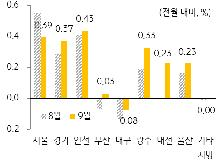

In [ ]:
# 관련 이미지를 반환합니다.
plt_img_base64(docs[3])

# 검증
이것이 왜 작동하는지, 우리가 저장했던 이미지를 다시 살펴보겠습니다.


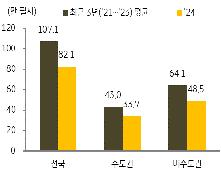

In [ ]:
# img_base64_list 리스트의 20번 index 이미지를 base64 형식으로 표시합니다.
plt_img_base64(img_base64_list[35])

In [ ]:
image_summaries[35]  # image_summaries 리스트의 네 번째 요소에 접근합니다.

"두 개의 막대그래프가 있으며, '전국', '수도권', '비수도권'으로 구분되어 있습니다. 초기 COVID-19 유행(21~22주)과 24주 데이터를 비교하고 있습니다. '전국'에서는 초기 유행 107.1, 24주 82.1이며, '수도권'은 초기 45.0, 24주 45.7, '비수도권'은 초기 54.1, 24주 48.5를 나타냅니다. 초기 유행 대비 24주 수치가 감소하거나 비슷한 경향을 보입니다."

In [ ]:
import json
rag_query = json.dumps(query)
# RAG 체인 실행
rag_chain = chain_multimodal_rag.invoke(rag_query)

In [ ]:
rag_chain

'KB금융지주 경영연구소의 자료에 따르면, 9월 전국 아파트 청약 경쟁률은 지역과 단지에 따라 다르게 나타날 수 있습니다. 일반적으로 인기 지역이나 대규모 개발 단지의 경우 경쟁률이 높게 나타나는 경향이 있습니다. \n\n최근 부동산 시장의 동향을 고려할 때, 수도권 및 주요 도시의 청약 경쟁률은 여전히 높은 수준을 유지할 가능성이 큽니다. 반면, 지방 중소도시의 경우 상대적으로 낮은 경쟁률을 보일 수 있습니다. \n\n정확한 경쟁률을 파악하기 위해서는 각 지역별 청약 공고 및 결과를 참고하는 것이 좋습니다. 추가적인 정보가 필요하다면, KB금융지주 경영연구소의 최신 보고서를 확인해 보시기 바랍니다.'